In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F

In [ ]:
#from:https://github.com/sunancui/breast-cancer-diagnosis
url = 'https://raw.githubusercontent.com/sunancui/breast-cancer-diagnosis/master/breast-cancer-wisconsin-data_data.csv'
data_all = pd.read_csv(url,index_col=0,parse_dates=[0])

In [ ]:
data_all

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [ ]:
data_features=data_all.iloc[:,1:11]
#read labels
data_diagnosis_l=data_all.iloc[:,0]
#label convert to numeric
data_diagnosis=data_diagnosis_l.replace("B",0)
data_diagnosis=data_diagnosis.replace("M",1)
#get values of X, Y
X=data_features.values
Y=data_diagnosis.values
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X, Y)
P=clf.predict(X)
P_P=clf.predict_proba(X)
sc=clf.score(X, Y)
#estimated optimal parameters
w_est=clf.coef_.reshape(-1,1)
b_est=clf.intercept_
eta=np.matmul(X,w_est)+b_est
result_df=pd.DataFrame(dict(label=Y, eta=eta.reshape(-1), prediction=P_P[:,1].reshape(-1)))
groups=result_df.groupby('label')
print('Classification score:',sc)

Classification score: 0.945518453427065


In [ ]:
input_dim=X.shape[1]
output_dim=1
learning_rate=0.1
num_epoch=1000
#convert to pytorch tensor
X_torch=torch.from_numpy(X)
Y_torch=torch.from_numpy(Y.reshape(-1,1))

In [ ]:
class LogisticRg(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRg, self).__init__()
        self.linear=torch.nn.Linear(input_dim,output_dim)
    def forward(self,x):
        outputs=torch.sigmoid(self.linear(x))
        return outputs
model=LogisticRg(input_dim,output_dim)
criterion=torch.nn.BCELoss(reduction='sum')
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(num_epoch):
    model.train()
    optimizer.zero_grad()
    y_pred=model(X_torch.float())
    #define the loss, adding l2 penalty
    loss=criterion(y_pred,Y_torch.float())
    #this is for matching the sklearn default setting, l2 penalty
    for l_w in model.parameters():
        loss=loss+torch.sum(l_w**2)*0.5
    loss.backward()
    optimizer.step()
    #if i%10==0:
        #print(i, loss)

In [ ]:
#final estimated, note this is roughly the same result as sklearn implemention, the
#slight difference may comes from numerical problems, different optimizer, learning rate.
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

linear.weight tensor([[ 0.9833,  1.3940,  0.9024,  1.3318,  0.9690, -0.3028,  1.0580,  1.5938,
          0.4266, -0.3943]])
linear.bias tensor([-0.5669])


In [ ]:
#from:https://www.kaggle.com/iabhishekbhardwaj/breast-cancer-prediction-wisconsin-data
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=6, random_state=123)
dtree.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Confusion Matrix:**

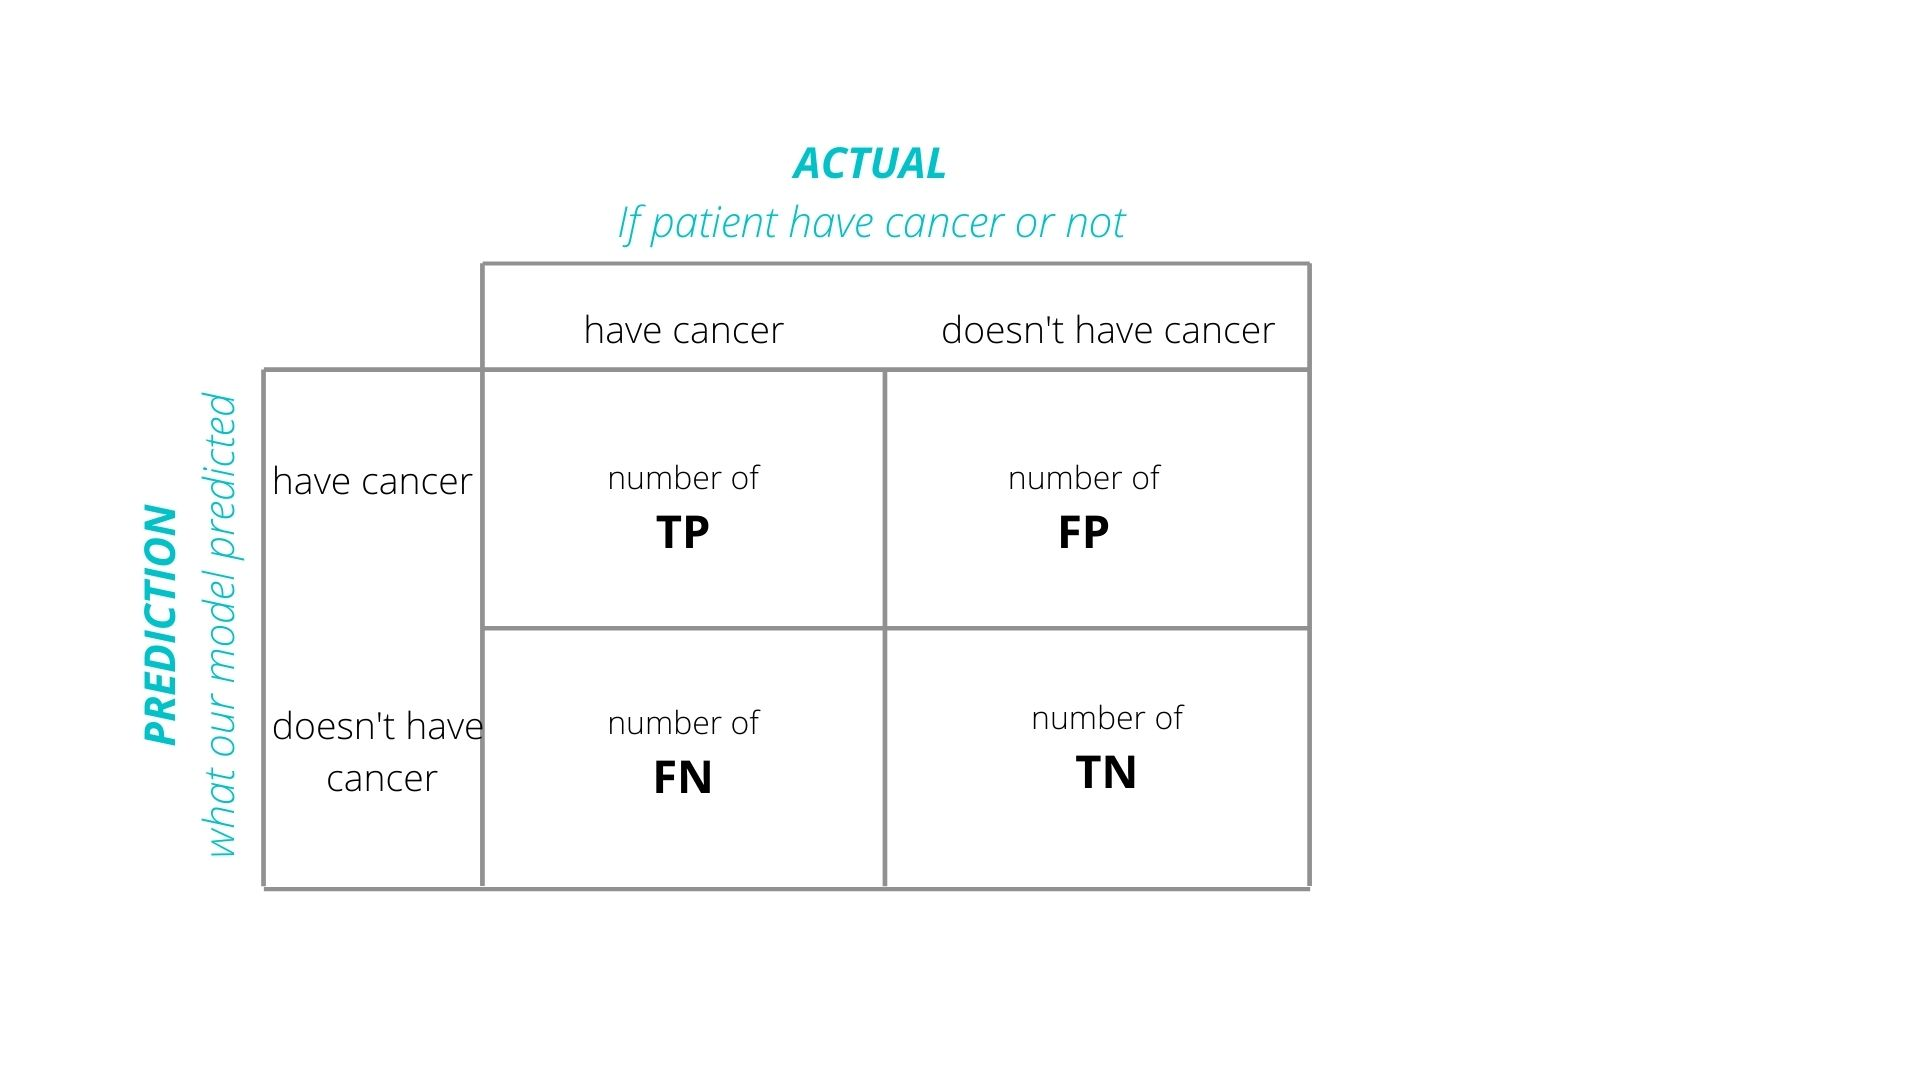

**Precision and Recall:**

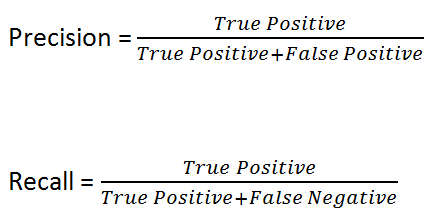**

In [ ]:
y_pred=dtree.predict(x_test)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,mean_squared_error
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",dtree.score(x_train,y_train)*100)
print("testing score:",accuracy_score(y_test,y_pred)*100)

Classification report:               precision    recall  f1-score   support

           0       0.95      0.94      0.95        67
           1       0.92      0.94      0.93        47

    accuracy                           0.94       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.94      0.94      0.94       114

Confusion Matrix: [[63  4]
 [ 3 44]]
Training Score:  99.34065934065934
testing score: 93.85964912280701


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=rfc.predict(x_test)
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",rfc.score(x_train,y_train)*100)
print("testing score:",accuracy_score(y_test,y_pred)*100)

Classification report:               precision    recall  f1-score   support

           0       0.98      0.94      0.96        67
           1       0.92      0.98      0.95        47

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix: [[63  4]
 [ 1 46]]
Training Score:  100.0
testing score: 95.6140350877193


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=7)

knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [ ]:
y_pred=knn.predict(x_test)
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",knn.score(x_train,y_train)*100)
print("Testing score",knn.score(x_test,y_test)*100)

Classification report:               precision    recall  f1-score   support

           0       0.95      0.90      0.92        67
           1       0.86      0.94      0.90        47

    accuracy                           0.91       114
   macro avg       0.91      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114

Confusion Matrix: [[60  7]
 [ 3 44]]
Training Score:  96.04395604395604
Testing score 91.22807017543859


In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred=svc.predict(x_test)
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",svc.score(x_train,y_train)*100)
print("Testing score:",svc.score(x_test,y_test))

Classification report:               precision    recall  f1-score   support

           0       0.93      0.97      0.95        67
           1       0.95      0.89      0.92        47

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114

Confusion Matrix: [[65  2]
 [ 5 42]]
Training Score:  96.48351648351648
Testing score: 0.9385964912280702


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(base_estimator = None)
adb.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
y_pred=adb.predict(x_test)
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",adb.score(x_train,y_train)*100)
print("testing score:",accuracy_score(y_test,y_pred)*100)

Classification report:               precision    recall  f1-score   support

           0       0.96      0.96      0.96        67
           1       0.94      0.94      0.94        47

    accuracy                           0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114

Confusion Matrix: [[64  3]
 [ 3 44]]
Training Score:  100.0
testing score: 94.73684210526315


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred=gbc.predict(x_test)
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",gbc.score(x_train,y_train)*100)
print("testing score:",gbc.score(x_test,y_test))

Classification report:               precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.94      0.96      0.95        47

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix: [[64  3]
 [ 2 45]]
Training Score:  100.0
testing score: 0.956140350877193


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred=gnb.predict(x_test)
print("Classification report:",classification_report(y_test,y_pred))
print("Confusion Matrix:",confusion_matrix(y_test,y_pred))
print("Training Score: ",gnb.score(x_train,y_train)*100)
print("Testing score",gnb.score(x_test,y_test))

Classification report:               precision    recall  f1-score   support

           0       0.90      0.91      0.90        67
           1       0.87      0.85      0.86        47

    accuracy                           0.89       114
   macro avg       0.88      0.88      0.88       114
weighted avg       0.89      0.89      0.89       114

Confusion Matrix: [[61  6]
 [ 7 40]]
Training Score:  92.08791208791209
Testing score 0.8859649122807017


References:

*   https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7331753/
*   https://github.com/sunancui/breast-cancer-diagnosis

